In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Examine series of models trained with 03_cvae_multi script

In [61]:
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoscaper.model.evaluation import calc_prompt_adherence
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation

from evoscaper.utils.preprocess import make_datetime_str


In [67]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

In [ ]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

dir_source = os.path.join('data', '03_cvae_multi', '2025_02_12__11_48_22')
dirs_source = [os.path.join('data', '03_cvae_multi', k) for k in ['2025_02_08__18_09_53', '2025_02_08__22_15_29', '2025_02_11__13_49_15', '2025_02_11__21_13_15']]
df_hpos = pd.DataFrame()
for d in dirs_source:
    fn_hpos = os.path.join(d, 'df_hpos_main.json')
    df_hpos_i = pd.read_json(fn_hpos)
    df_hpos = pd.concat([df_hpos, df_hpos_i[df_hpos_i['R2_train'] != 'TO_BE_RECORDED']], axis=0)
df_hpos = df_hpos.sort_index()
df_hpos = df_hpos[df_hpos['R2_train'].apply(lambda x: x > 0 if type(x) != str else True)]
df_hpos['mutual_information_conditionality'] = df_hpos['mutual_information_conditionality'].apply(lambda x: np.mean(x) if type(x) == list else x)


In [48]:
output_idx = -1
perc_recall=0.01
df_hpos['precision'] = np.nan
df_hpos['recall'] = np.nan
df_hpos['f1'] = np.nan
for i, r in df_hpos.iterrows():
    curr_dir = os.path.dirname(r['filename_saved_model'])
    fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
    fn_analytics = os.path.join(curr_dir, 'analytics.json')
    if r['R2_train'] > 0.8 and os.path.exists(fn_sample) and os.path.exists(fn_analytics):
        sampled_cond = np.load(fn_sample)
        analytics = load_json_as_dict(fn_analytics)
        analytics['adaptation'] = calculate_adaptation(
            np.array(analytics['sensitivity_wrt_species-6']), np.array(analytics['precision_wrt_species-6']))
        a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None] for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
        precision, recall, f1 = calc_prompt_adherence(sampled_cond, a, perc_recall=perc_recall)
        df_hpos.loc[i, 'precision'] = precision.mean()
        df_hpos.loc[i, 'recall'] = recall.mean()
        df_hpos.loc[i, 'f1'] = f1.mean()



In [49]:
df_hpos.loc[~df_hpos['use_kl_div'], 'kl_weight'] = np.nan
df_hpos['threshold_early_val_acc'] = df_hpos['threshold_early_val_acc'].apply(np.float32)

for c in df_hpos.columns:
    if df_hpos[c].dtype == bool:
        df_hpos[c] = df_hpos[c].astype(str)
        

In [50]:
df_hpos['kl_weight'] = df_hpos['kl_weight'] * 1e4
df_hpos.rename(columns={'kl_weight': 'kl_weight x10e-4'}, inplace=True)


In [59]:
cols_output = ['R2_train', 'precision', 'recall', 'f1']
cols_exclude = ['R2_test', 'mutual_information_conditionality']
df_hpos = df_hpos[(df_hpos != 'TO_BE_RECORDED').all(axis=1)]
cols_input = [c for c in df_hpos.columns if c not in cols_output]
for c in df_hpos.columns:
    if type(df_hpos[c].iloc[0]) == list: 
        df_hpos[c] = df_hpos[c].apply(lambda x: ',\n'.join(x) if (x is not None) and (type(x[0]) == str) else np.array(x))
cols_meta = ['filename_saved_model', 'run_successful', 'info_early_stop', 'error_msg', 'total_ds', 'n_batches', 'n_layers_enc', 'n_layers_dec']
cols_exclude = cols_exclude + cols_meta
# cols_outmetric = [c for c in cols_output if c not in cols_meta and (c != 'mutual_information_conditionality')]
cols_outmetric = ['R2_train', 'precision', 'recall', 'f1']
cols_varying = [c for c in cols_input if (df_hpos[c].nunique() > 1) and c not in cols_exclude]

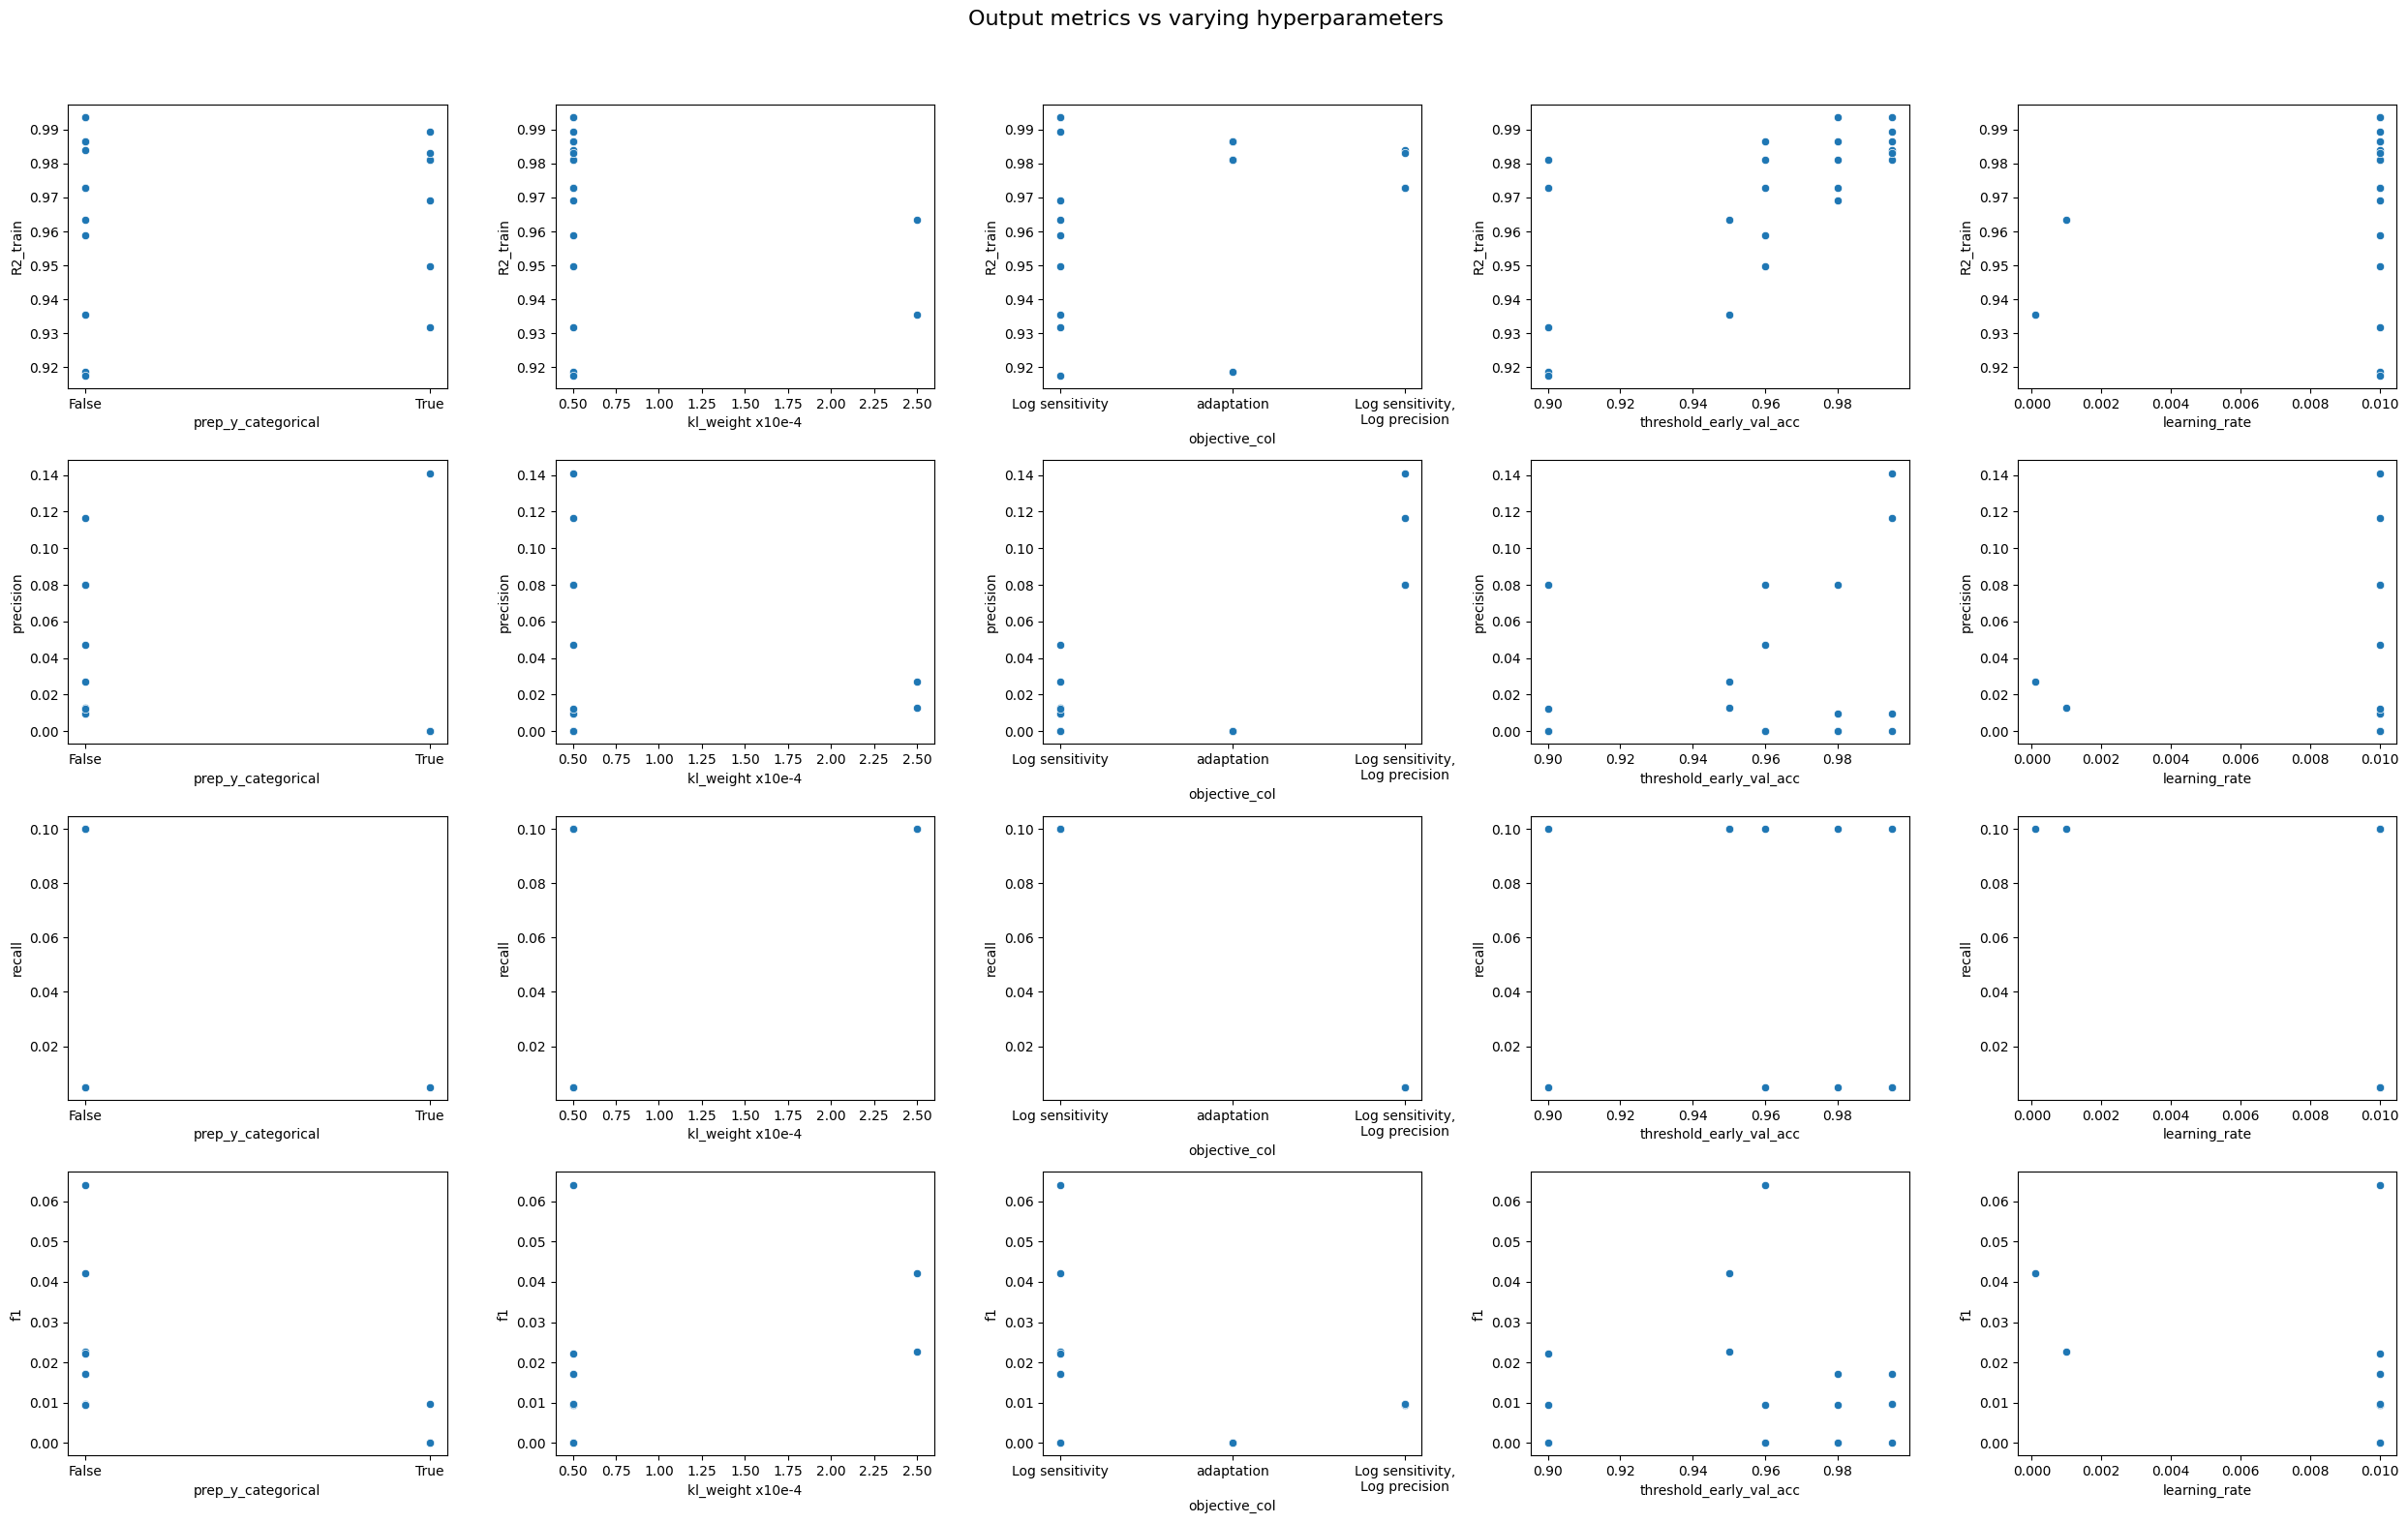

In [ ]:
nrows = len(cols_outmetric)
ncols = len(cols_varying)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
j = 0
for j, kj in enumerate(cols_outmetric):
    for i, k in enumerate(cols_varying):
        sns.scatterplot(data=df_hpos, x=k, y=cols_outmetric[j], ax=axes[j, i])
plt.suptitle(f'Output metrics vs varying hyperparameters', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.savefig(os.path.join(top_write_dir, 'varying_vs_output_metrics.png'), dpi=300, bbox_inches='tight', transparent=True)


In [53]:
hpos_to_vary_together = [{
    'objective_col': [('adaptation',), ('Log sensitivity',), ('Log sensitivity', 'Log precision')],
    'prep_y_categorical': [False, True],
    'use_kl_div': [True],
    # 'kl_weight': [5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4],
    'kl_weight x10e-3': np.array([5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4]) * 1e3,
    'threshold_early_val_acc': [0.995, 0.98, 0.96, 0.9],
},
    {
    'use_contrastive_loss': [True],
    'temperature': [0.1, 0.5, 1, 1.5, 2, 4, 8],
    'threshold_similarity': [0.95, 0.9, 0.7, 0.5, 0.3, 0.1],
    'power_factor_distance': [3, 4],
    'threshold_early_val_acc': [0.995, 0.9]
}]

In [54]:
for h in hpos_to_vary_together:
    h_keys = [c for c in h.keys() if df_hpos[c].nunique() > 1]
    combinations = sorted(set([tuple(sorted([i, j])) for i, j in itertools.combinations(h_keys, 2)]))
    ncols = len(combinations)
    nrows = len(cols_outmetric)
    if ncols > 0:
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        for j, kj in enumerate(cols_outmetric):
            for i, (k1, k2) in enumerate(combinations):
                if df_hpos[k1].dtype == object and (df_hpos[k2].iloc[0] not in ['True', 'False']):
                    f = sns.violinplot
                else:
                    f = sns.scatterplot
                f(data=df_hpos, x=k1, y=kj, hue=k2, ax=axes[j, i])
        plt.suptitle('Co-varying: ' + ', '.join(h_keys))
        plt.tight_layout()
        

KeyError: 'kl_weight x10e-3'